In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! kaggle datasets download -d nikhilroxtomar/ct-heart-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/ct-heart-segmentation
License(s): unknown
 98% 530M/541M [00:05<00:00, 152MB/s]
100% 541M/541M [00:05<00:00, 105MB/s]


In [ ]:
! unzip ct-heart-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/100051/image/1-065.png  
  inflating: data/train/100051/image/1-066.png  
  inflating: data/train/100051/image/1-067.png  
  inflating: data/train/100051/image/1-068.png  
  inflating: data/train/100051/image/1-069.png  
  inflating: data/train/100051/image/1-070.png  
  inflating: data/train/100051/image/1-071.png  
  inflating: data/train/100051/image/1-072.png  
  inflating: data/train/100051/image/1-073.png  
  inflating: data/train/100051/image/1-074.png  
  inflating: data/train/100051/image/1-075.png  
  inflating: data/train/100051/image/1-076.png  
  inflating: data/train/100051/image/1-077.png  
  inflating: data/train/100051/image/1-078.png  
  inflating: data/train/100051/image/1-079.png  
  inflating: data/train/100051/image/1-080.png  
  inflating: data/train/100051/image/1-081.png  
  inflating: data/train/100051/image/1-082.png  
  inflating: data/train/100051/image/1-083.png  
  inflating: data/

In [ ]:

import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
#os.chdir(r"E:\UNET CT")

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.2):
    """ Load the images and masks """
    images = sorted(glob(f"{path}/*/image/*.png"))
    masks = sorted(glob(f"{path}/*/mask/*.png"))

    """ Split the data """
    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    H = 256
    W = 256

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the dir name and image name """
        dir_name = x.split("/")[-3]
        name = dir_name + "_" + x.split("/")[-1].split(".")[0]

        """ Read the image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        augmentation_pipeline = A.Compose([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),  # Adjust brightness and contrast
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.7),  # Adjust hue, saturation, and value
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.7),  # Shift RGB channels
            A.RandomGamma(gamma_limit=(80, 120), p=0.7),  # Random gamma adjustment
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.7),  # Contrast Limited Adaptive Histogram Equalization
            A.ChannelShuffle(p=0.7),  # Randomly shuffle channels
         ])

        X = [x]
        Y = [y]

        if augment == True:
          for _ in range(9):
            augmented = augmentation_pipeline(image=x,mask=y)
            X.append(augmented["image"])
            Y.append(augmented["mask"])



        idx = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            m = m/255.0
            m = (m > 0.5) * 255

            if len(X) == 1:  # each loop it will take one image
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name  = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{idx}.jpg"
                tmp_mask_name  = f"{name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx = idx + 1
        #break


if __name__ == "__main__":
    """ Load the dataset """
    dataset_path = os.path.join("data", "train")
    (train_x, train_y), (valid_x, valid_y) = load_data(dataset_path, split=0.2)

    print("Train: ", len(train_x))
    print("Valid: ", len(valid_x))

    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/valid/image/")
    create_dir("new_data/valid/mask/")

    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(valid_x, valid_y, "new_data/valid/", augment=False)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Train:  2026
Valid:  506


100%|██████████| 506/506 [00:04<00:00, 120.24it/s]


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

def conv_block(input, num_filters, drop = 0.0):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(drop)(x)

    return x


def encoder_block(input, num_filters, drop = 0.0):
    x = conv_block(input, num_filters, drop)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters, drop = 0.0):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, drop)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)
    s4, p4 = encoder_block(p3, 64)
    s5, p5 = encoder_block(p4, 128, 0.3)

    b1 = conv_block(p5, 256, 0.3)

    d1 = decoder_block(b1, s5, 128, 0.3)
    d2 = decoder_block(d1, s4, 64)
    d3 = decoder_block(d2, s3, 32)
    d4 = decoder_block(d3, s2, 16)
    d5 = decoder_block(d4, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs, name="U-Net")
    return model


if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 256, 256, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 256, 256, 16)   │             64 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 256, 256, 16)   │              0 │ activation_14[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 256, 256, 16)   │             64 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 256, 256, 16)   │              0 │ activation_15[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 128, 128, 16)   │              0 │ dropout_15[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 128, 128, 16)   │             64 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 128, 128, 16)   │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 1,959,873 (7.48 MB)

 Trainable params: 1,956,801 (7.46 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    """Calculate IOU using pure TensorFlow operations"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    # Add smooth factor to avoid division by zero
    iou_score = (intersection + 1e-15) / (union + 1e-15)
    return iou_score


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
#from model import unet
#from metrics import dice_loss, dice_coef, iou

H = 256
W = 256

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 16
    lr = 1e-4
    num_epochs = 20
    model_path = os.path.join("files", "model.keras")
    csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = os.path.join("new_data")
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "valid")

    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    #def schedule(epoch, lr):
    #    return lr * 0.85  # Reduce learning rate by 10% after each epoch

    # Create the LearningRateScheduler callback
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
        #lr_scheduler,
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
    ]

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        shuffle=False
    )

Train: 20260 - 20260
Valid: 506 - 506
Epoch 1/20
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - dice_coef: 0.1516 - iou: 0.0839 - loss: 0.8484 - precision: 0.1687 - recall: 0.9645
Epoch 1: val_loss improved from inf to 0.70630, saving model to files/model.keras
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 212s 130ms/step - dice_coef: 0.1517 - iou: 0.0839 - loss: 0.8483 - precision: 0.1687 - recall: 0.9645 - val_dice_coef: 0.2924 - val_iou: 0.1854 - val_loss: 0.7063 - val_precision: 0.8023 - val_recall: 0.9558 - learning_rate: 1.0000e-04
Epoch 2/20
1266/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - dice_coef: 0.4252 - iou: 0.2785 - loss: 0.5748 - precision: 0.7811 - recall: 0.9684
Epoch 2: val_loss improved from 0.70630 to 0.41991, saving model to files/model.keras
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 144s 114ms/step - dice_coef: 0.4254 - iou: 0.2786 - loss: 0.5746 - precision: 0.7811 - recall: 0.9683 - val_dice_coef: 0.5795 - val_iou: 0.4493 - val_loss: 0.4199 - val_precision: 0.8979 - val_recall: 0.9431 - le

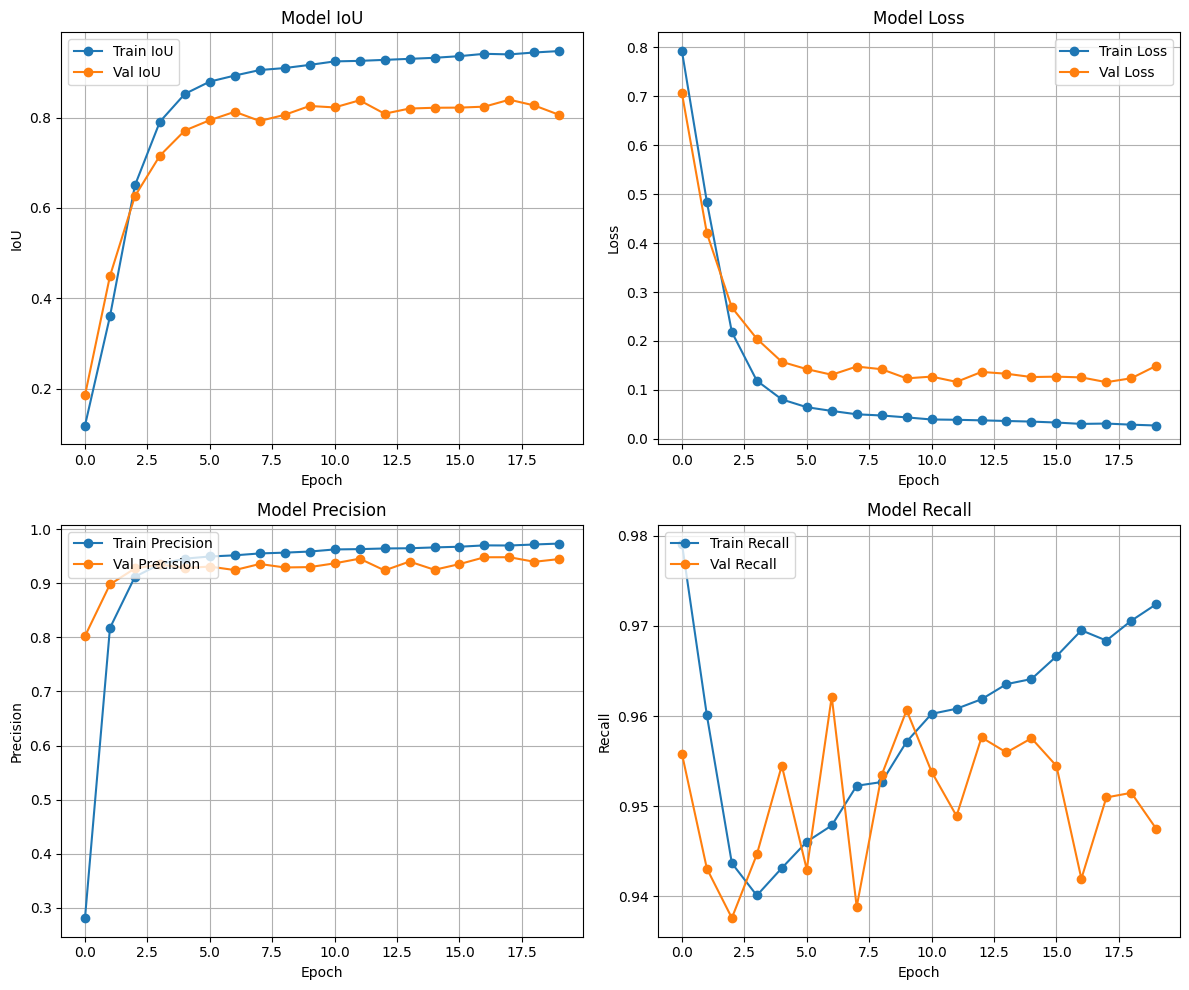

In [ ]:
import matplotlib.pyplot as plt

# Define a figure with an appropriate size
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot IoU
axes[0, 0].plot(history.history['iou'], label='Train IoU', marker='o')
axes[0, 0].plot(history.history['val_iou'], label='Val IoU', marker='o')
axes[0, 0].set_title('Model IoU')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('IoU')
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True)

# Plot Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss', marker='o')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend(loc='upper right')
axes[0, 1].grid(True)

# Plot Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', marker='o')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', marker='o')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True)

# Plot Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', marker='o')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', marker='o')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend(loc='upper left')
axes[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/CT_Heart/best_model.keras')

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
#from train import load_data

H = 256
W = 256

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):
    ## i - m - y
    line = np.ones((H, 10, 3)) * 128

    """ Mask """
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    """ Predicted Mask """
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.keras")

    """ Load the dataset """
    test_x = sorted(glob(os.path.join("new_data", "valid", "image", "*")))
    test_y = sorted(glob(os.path.join("new_data", "valid", "mask", "*")))
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = mask/255.0
        y = y > 0.5
        y = y.astype(np.int32)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = f"results/{name}.png"
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

Test: 506 - 506


  0%|          | 0/506 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|          | 1/506 [00:02<22:29,  2.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  0%|          | 2/506 [00:02<09:53,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  1%|          | 3/506 [00:03<06:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  1%|          | 4/506 [00:03<04:20,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|          | 5/506 [00:03<03:15,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|          | 6/506 [00:03<02:42,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  1%|▏         | 7/506 [00:03<02:22,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|▏         | 8/506 [00:03<02:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  2%|▏         | 9/506 [00:04<01:48,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  2%|▏         | 10/506 [00:04<01:47,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|▏         | 11/506 [00:04<01:42,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|▏         | 12/506 [00:04<01:39,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 13/506 [00:04<01:37,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  3%|▎         | 14/506 [00:05<01:35,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|▎         | 15/506 [00:05<01:33,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  3%|▎         | 16/506 [00:05<01:30,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  3%|▎         | 17/506 [00:05<01:32,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  4%|▎         | 18/506 [00:05<01:32,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  4%|▍         | 19/506 [00:05<01:34,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  4%|▍         | 20/506 [00:06<01:35,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  4%|▍         | 21/506 [00:06<01:36,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 22/506 [00:06<01:30,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 23/506 [00:06<01:19,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 24/506 [00:06<01:12,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▍         | 25/506 [00:06<01:11,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 26/506 [00:07<01:11,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 27/506 [00:07<01:10,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 28/506 [00:07<01:10,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 29/506 [00:07<01:10,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 30/506 [00:07<01:06,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 31/506 [00:07<01:02,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▋         | 32/506 [00:07<01:05,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 33/506 [00:08<01:01,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  7%|▋         | 34/506 [00:08<01:04,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 35/506 [00:08<01:01,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 36/506 [00:08<01:01,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 37/506 [00:08<01:09,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 38/506 [00:08<01:13,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 39/506 [00:08<01:12,  6.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 40/506 [00:09<01:06,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 41/506 [00:09<01:07,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 42/506 [00:09<01:02,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 43/506 [00:09<01:03,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  9%|▊         | 44/506 [00:09<01:06,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  9%|▉         | 45/506 [00:09<01:02,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  9%|▉         | 46/506 [00:09<01:04,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 47/506 [00:09<01:00,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 48/506 [00:10<00:57,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 49/506 [00:10<01:00,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|▉         | 50/506 [00:10<01:04,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|█         | 51/506 [00:10<01:06,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 52/506 [00:10<01:02,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 10%|█         | 53/506 [00:10<00:58,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 11%|█         | 54/506 [00:10<00:56,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 55/506 [00:11<00:55,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 56/506 [00:11<00:58,  7.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 11%|█▏        | 57/506 [00:11<00:56,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█▏        | 58/506 [00:11<01:00,  7.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 12%|█▏        | 59/506 [00:11<00:58,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 60/506 [00:11<01:00,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 61/506 [00:11<01:02,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 62/506 [00:11<00:58,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▏        | 63/506 [00:12<00:56,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 64/506 [00:12<00:58,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 65/506 [00:12<00:55,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 13%|█▎        | 66/506 [00:12<00:59,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 13%|█▎        | 67/506 [00:12<01:02,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 13%|█▎        | 68/506 [00:12<01:02,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 69/506 [00:12<01:00,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 14%|█▍        | 70/506 [00:13<01:01,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 71/506 [00:13<00:57,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▍        | 72/506 [00:13<00:55,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 73/506 [00:13<01:00,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▍        | 74/506 [00:13<00:58,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 75/506 [00:13<00:54,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▌        | 76/506 [00:13<00:57,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 77/506 [00:14<00:59,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 78/506 [00:14<00:55,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 79/506 [00:14<00:57,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 16%|█▌        | 80/506 [00:14<00:55,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 16%|█▌        | 81/506 [00:14<00:57,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 82/506 [00:14<00:59,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▋        | 83/506 [00:14<00:56,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|█▋        | 84/506 [00:14<00:54,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 85/506 [00:15<00:56,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 17%|█▋        | 86/506 [00:15<00:58,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 87/506 [00:15<00:55,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 88/506 [00:15<00:54,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 89/506 [00:15<00:58,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 90/506 [00:15<00:58,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 91/506 [00:15<00:55,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 92/506 [00:16<00:52,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 93/506 [00:16<00:50,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 19%|█▊        | 94/506 [00:16<00:50,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 95/506 [00:16<00:49,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 19%|█▉        | 96/506 [00:16<00:55,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 97/506 [00:16<01:03,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 98/506 [00:16<01:07,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|█▉        | 99/506 [00:17<01:06,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|█▉        | 100/506 [00:17<01:09,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|█▉        | 101/506 [00:17<01:13,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|██        | 102/506 [00:17<01:14,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 103/506 [00:17<01:15,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 104/506 [00:18<01:12,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██        | 105/506 [00:18<01:14,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██        | 106/506 [00:18<01:14,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 107/506 [00:18<01:15,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██▏       | 108/506 [00:18<01:16,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 22%|██▏       | 109/506 [00:18<01:16,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 110/506 [00:19<01:15,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 22%|██▏       | 111/506 [00:19<01:16,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 22%|██▏       | 112/506 [00:19<01:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 22%|██▏       | 113/506 [00:19<01:17,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|██▎       | 114/506 [00:19<01:17,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 23%|██▎       | 115/506 [00:20<01:15,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 116/506 [00:20<01:05,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 117/506 [00:20<00:59,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 23%|██▎       | 118/506 [00:20<00:57,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▎       | 119/506 [00:20<00:53,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▎       | 120/506 [00:20<00:51,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 121/506 [00:20<00:53,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 122/506 [00:21<00:54,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 123/506 [00:21<00:50,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 124/506 [00:21<00:52,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▍       | 125/506 [00:21<00:50,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 126/506 [00:21<00:49,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 127/506 [00:21<00:48,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 128/506 [00:21<00:48,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 25%|██▌       | 129/506 [00:21<00:46,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 130/506 [00:22<00:45,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 131/506 [00:22<00:48,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 132/506 [00:22<00:46,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▋       | 133/506 [00:22<00:46,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▋       | 134/506 [00:22<00:47,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 135/506 [00:22<00:45,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 136/506 [00:22<00:45,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 137/506 [00:22<00:48,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 138/506 [00:23<00:46,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 139/506 [00:23<00:46,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 140/506 [00:23<00:45,  8.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 141/506 [00:23<00:48,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 142/506 [00:23<00:48,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 143/506 [00:23<00:46,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 28%|██▊       | 144/506 [00:23<00:48,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▊       | 145/506 [00:24<00:49,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 146/506 [00:24<00:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 147/506 [00:24<00:48,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 148/506 [00:24<00:46,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 149/506 [00:24<00:49,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 150/506 [00:24<00:50,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 151/506 [00:24<00:49,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 152/506 [00:24<00:49,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|███       | 153/506 [00:25<00:46,  7.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 154/506 [00:25<00:48,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 155/506 [00:25<00:46,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 156/506 [00:25<00:45,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███       | 157/506 [00:25<00:48,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 158/506 [00:25<00:45,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 159/506 [00:25<00:47,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 160/506 [00:26<00:48,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 161/506 [00:26<00:48,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 162/506 [00:26<00:49,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 163/506 [00:26<00:50,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 164/506 [00:26<00:50,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 165/506 [00:26<00:46,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 166/506 [00:26<00:45,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 167/506 [00:27<00:46,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 168/506 [00:27<00:44,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 169/506 [00:27<00:42,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 170/506 [00:27<00:41,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 171/506 [00:27<00:44,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 172/506 [00:27<00:46,  7.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 173/506 [00:27<00:43,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▍      | 174/506 [00:27<00:43,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 35%|███▍      | 175/506 [00:28<00:45,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▍      | 176/506 [00:28<00:43,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 177/506 [00:28<00:41,  7.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 178/506 [00:28<00:44,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 179/506 [00:28<00:43,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 180/506 [00:28<00:44,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 181/506 [00:28<00:45,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 36%|███▌      | 182/506 [00:29<00:46,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 183/506 [00:29<00:43,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 184/506 [00:29<00:44,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 185/506 [00:29<00:42,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 186/506 [00:29<00:45,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 187/506 [00:29<00:43,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 188/506 [00:29<00:41,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 189/506 [00:29<00:41,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 190/506 [00:30<00:42,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 38%|███▊      | 191/506 [00:30<00:46,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 38%|███▊      | 192/506 [00:30<00:50,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 193/506 [00:30<00:51,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 194/506 [00:30<00:51,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███▊      | 195/506 [00:30<00:50,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 39%|███▊      | 196/506 [00:31<00:53,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███▉      | 197/506 [00:31<00:52,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 198/506 [00:31<00:55,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 39%|███▉      | 199/506 [00:31<00:57,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███▉      | 200/506 [00:31<00:54,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███▉      | 201/506 [00:32<00:56,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 40%|███▉      | 202/506 [00:32<00:57,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|████      | 203/506 [00:32<00:56,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 40%|████      | 204/506 [00:32<00:56,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 41%|████      | 205/506 [00:32<00:57,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 41%|████      | 206/506 [00:33<00:58,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████      | 207/506 [00:33<00:55,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 208/506 [00:33<00:57,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 41%|████▏     | 209/506 [00:33<00:58,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 42%|████▏     | 210/506 [00:33<00:58,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 42%|████▏     | 211/506 [00:34<00:57,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 212/506 [00:34<00:53,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 213/506 [00:34<00:47,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 214/506 [00:34<00:44,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 215/506 [00:34<00:44,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 216/506 [00:34<00:41,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 217/506 [00:34<00:41,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 218/506 [00:34<00:39,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 219/506 [00:35<00:37,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 220/506 [00:35<00:39,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▎     | 221/506 [00:35<00:40,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 222/506 [00:35<00:41,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████▍     | 223/506 [00:35<00:41,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 224/506 [00:35<00:41,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 225/506 [00:35<00:41,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 226/506 [00:36<00:38,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|████▍     | 227/506 [00:36<00:37,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▌     | 228/506 [00:36<00:38,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 229/506 [00:36<00:38,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 230/506 [00:36<00:39,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 231/506 [00:36<00:37,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 232/506 [00:36<00:38,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 233/506 [00:37<00:39,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 234/506 [00:37<00:39,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▋     | 235/506 [00:37<00:40,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|████▋     | 236/506 [00:37<00:40,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 237/506 [00:37<00:40,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 238/506 [00:37<00:37,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 239/506 [00:37<00:35,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 240/506 [00:38<00:34,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 241/506 [00:38<00:36,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 242/506 [00:38<00:37,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|████▊     | 243/506 [00:38<00:38,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 244/506 [00:38<00:36,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 245/506 [00:38<00:34,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▊     | 246/506 [00:38<00:35,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▉     | 247/506 [00:39<00:34,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 248/506 [00:39<00:35,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 249/506 [00:39<00:34,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 250/506 [00:39<00:36,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|████▉     | 251/506 [00:39<00:35,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 252/506 [00:39<00:33,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 253/506 [00:39<00:34,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 254/506 [00:40<00:35,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 255/506 [00:40<00:32,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 256/506 [00:40<00:31,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 51%|█████     | 257/506 [00:40<00:33,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 258/506 [00:40<00:33,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 259/506 [00:40<00:34,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 260/506 [00:40<00:33,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 261/506 [00:40<00:31,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 262/506 [00:41<00:33,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 263/506 [00:41<00:33,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 264/506 [00:41<00:32,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 265/506 [00:41<00:31,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 266/506 [00:41<00:33,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 267/506 [00:41<00:33,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 268/506 [00:41<00:32,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 269/506 [00:42<00:33,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 270/506 [00:42<00:31,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 54%|█████▎    | 271/506 [00:42<00:33,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 272/506 [00:42<00:34,  6.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 273/506 [00:42<00:32,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 274/506 [00:42<00:33,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 275/506 [00:42<00:31,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 276/506 [00:43<00:32,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 277/506 [00:43<00:30,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▍    | 278/506 [00:43<00:29,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 279/506 [00:43<00:29,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▌    | 280/506 [00:43<00:31,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 281/506 [00:43<00:29,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 282/506 [00:43<00:28,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 283/506 [00:43<00:28,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████▌    | 284/506 [00:44<00:30,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▋    | 285/506 [00:44<00:34,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 57%|█████▋    | 286/506 [00:44<00:38,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 57%|█████▋    | 287/506 [00:44<00:40,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 288/506 [00:44<00:40,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 57%|█████▋    | 289/506 [00:45<00:40,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 57%|█████▋    | 290/506 [00:45<00:40,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████▊    | 291/506 [00:45<00:40,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 292/506 [00:45<00:41,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 58%|█████▊    | 293/506 [00:45<00:39,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 294/506 [00:46<00:39,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 295/506 [00:46<00:38,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|█████▊    | 296/506 [00:46<00:38,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 59%|█████▊    | 297/506 [00:46<00:40,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|█████▉    | 298/506 [00:46<00:38,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 59%|█████▉    | 299/506 [00:46<00:38,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 300/506 [00:47<00:39,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 59%|█████▉    | 301/506 [00:47<00:40,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 60%|█████▉    | 302/506 [00:47<00:41,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|█████▉    | 303/506 [00:47<00:40,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|██████    | 304/506 [00:47<00:36,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|██████    | 305/506 [00:48<00:32,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 306/506 [00:48<00:29,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 307/506 [00:48<00:27,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 308/506 [00:48<00:26,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 309/506 [00:48<00:26,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████▏   | 310/506 [00:48<00:27,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 311/506 [00:48<00:27,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 312/506 [00:48<00:28,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 313/506 [00:49<00:25,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 314/506 [00:49<00:24,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 315/506 [00:49<00:24,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 316/506 [00:49<00:25,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 317/506 [00:49<00:24,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 318/506 [00:49<00:25,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 319/506 [00:49<00:26,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 320/506 [00:50<00:27,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 321/506 [00:50<00:27,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▎   | 322/506 [00:50<00:25,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 323/506 [00:50<00:24,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 324/506 [00:50<00:25,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 325/506 [00:50<00:26,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 326/506 [00:50<00:25,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 327/506 [00:51<00:25,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▍   | 328/506 [00:51<00:23,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 329/506 [00:51<00:24,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 330/506 [00:51<00:25,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 331/506 [00:51<00:26,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 332/506 [00:51<00:24,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 333/506 [00:51<00:25,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 334/506 [00:52<00:25,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 335/506 [00:52<00:25,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▋   | 336/506 [00:52<00:24,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 337/506 [00:52<00:25,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 338/506 [00:52<00:25,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 339/506 [00:52<00:24,  6.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 67%|██████▋   | 340/506 [00:52<00:22,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 341/506 [00:53<00:23,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 342/506 [00:53<00:21,  7.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 343/506 [00:53<00:22,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 344/506 [00:53<00:21,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████▊   | 345/506 [00:53<00:22,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 68%|██████▊   | 346/506 [00:53<00:23,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▊   | 347/506 [00:53<00:23,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 348/506 [00:54<00:22,  7.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 349/506 [00:54<00:22,  6.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▉   | 350/506 [00:54<00:22,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 351/506 [00:54<00:21,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 352/506 [00:54<00:22,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 353/506 [00:54<00:23,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 354/506 [00:54<00:22,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|███████   | 355/506 [00:55<00:21,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 356/506 [00:55<00:20,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 357/506 [00:55<00:21,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 358/506 [00:55<00:20,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 359/506 [00:55<00:21,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 360/506 [00:55<00:21,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 361/506 [00:55<00:20,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 362/506 [00:56<00:20,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 363/506 [00:56<00:20,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 364/506 [00:56<00:20,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 365/506 [00:56<00:21,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 366/506 [00:56<00:19,  7.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 367/506 [00:56<00:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 368/506 [00:56<00:19,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 369/506 [00:57<00:19,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 370/506 [00:57<00:19,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 371/506 [00:57<00:19,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 372/506 [00:57<00:20,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▎  | 373/506 [00:57<00:19,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 374/506 [00:57<00:19,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 74%|███████▍  | 375/506 [00:57<00:21,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 376/506 [00:58<00:22,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 377/506 [00:58<00:21,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|███████▍  | 378/506 [00:58<00:21,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▍  | 379/506 [00:58<00:22,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 75%|███████▌  | 380/506 [00:58<00:23,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▌  | 381/506 [00:59<00:22,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▌  | 382/506 [00:59<00:22,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 76%|███████▌  | 383/506 [00:59<00:23,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 384/506 [00:59<00:23,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|███████▌  | 385/506 [00:59<00:23,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|███████▋  | 386/506 [01:00<00:22,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 387/506 [01:00<00:21,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|███████▋  | 388/506 [01:00<00:21,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 77%|███████▋  | 389/506 [01:00<00:21,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 390/506 [01:00<00:20,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 391/506 [01:00<00:21,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 77%|███████▋  | 392/506 [01:01<00:21,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 393/506 [01:01<00:21,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 78%|███████▊  | 394/506 [01:01<00:22,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 395/506 [01:01<00:21,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 396/506 [01:01<00:21,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 397/506 [01:02<00:20,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▊  | 398/506 [01:02<00:18,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 399/506 [01:02<00:17,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 400/506 [01:02<00:16,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 401/506 [01:02<00:15,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 402/506 [01:02<00:15,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 403/506 [01:02<00:14,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 404/506 [01:03<00:13,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 405/506 [01:03<00:13,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 406/506 [01:03<00:13,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 407/506 [01:03<00:14,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 408/506 [01:03<00:14,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 409/506 [01:03<00:14,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 410/506 [01:03<00:14,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 411/506 [01:04<00:13,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████▏ | 412/506 [01:04<00:13,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 413/506 [01:04<00:12,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 414/506 [01:04<00:12,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 415/506 [01:04<00:13,  6.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 416/506 [01:04<00:13,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 417/506 [01:04<00:13,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 418/506 [01:05<00:13,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 419/506 [01:05<00:12,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 420/506 [01:05<00:12,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 421/506 [01:05<00:12,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 422/506 [01:05<00:12,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▎ | 423/506 [01:05<00:12,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 424/506 [01:05<00:11,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 425/506 [01:06<00:11,  7.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 426/506 [01:06<00:11,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 427/506 [01:06<00:11,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|████████▍ | 428/506 [01:06<00:11,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 429/506 [01:06<00:10,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▍ | 430/506 [01:06<00:10,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 431/506 [01:06<00:10,  7.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 432/506 [01:07<00:09,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 433/506 [01:07<00:09,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 434/506 [01:07<00:09,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 435/506 [01:07<00:09,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 436/506 [01:07<00:09,  7.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 437/506 [01:07<00:09,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 438/506 [01:07<00:09,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 439/506 [01:07<00:08,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 440/506 [01:08<00:08,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 441/506 [01:08<00:09,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 442/506 [01:08<00:09,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 443/506 [01:08<00:08,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 444/506 [01:08<00:08,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 445/506 [01:08<00:08,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 446/506 [01:08<00:08,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 447/506 [01:09<00:07,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 448/506 [01:09<00:07,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 449/506 [01:09<00:08,  6.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 450/506 [01:09<00:07,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 451/506 [01:09<00:07,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 452/506 [01:09<00:07,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 453/506 [01:09<00:07,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 454/506 [01:10<00:07,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 455/506 [01:10<00:06,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 456/506 [01:10<00:07,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|█████████ | 457/506 [01:10<00:06,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 458/506 [01:10<00:06,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 459/506 [01:10<00:06,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 460/506 [01:10<00:06,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 461/506 [01:11<00:05,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████▏| 462/506 [01:11<00:05,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 463/506 [01:11<00:05,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 464/506 [01:11<00:05,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 465/506 [01:11<00:05,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 466/506 [01:11<00:05,  7.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 467/506 [01:11<00:05,  7.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 468/506 [01:12<00:05,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 469/506 [01:12<00:05,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 470/506 [01:12<00:05,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|█████████▎| 471/506 [01:12<00:06,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|█████████▎| 472/506 [01:12<00:05,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 473/506 [01:12<00:05,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|█████████▎| 474/506 [01:13<00:05,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 475/506 [01:13<00:05,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|█████████▍| 476/506 [01:13<00:05,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 94%|█████████▍| 477/506 [01:13<00:05,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 478/506 [01:13<00:04,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 479/506 [01:14<00:04,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▍| 480/506 [01:14<00:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████▌| 481/506 [01:14<00:04,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 95%|█████████▌| 482/506 [01:14<00:04,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 483/506 [01:14<00:04,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▌| 484/506 [01:14<00:04,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 485/506 [01:15<00:03,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 486/506 [01:15<00:03,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 96%|█████████▌| 487/506 [01:15<00:03,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 96%|█████████▋| 488/506 [01:15<00:03,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 97%|█████████▋| 489/506 [01:15<00:03,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 97%|█████████▋| 490/506 [01:16<00:03,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 491/506 [01:16<00:03,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 492/506 [01:16<00:02,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 493/506 [01:16<00:02,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 494/506 [01:16<00:02,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 495/506 [01:16<00:01,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 496/506 [01:17<00:01,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 497/506 [01:17<00:01,  7.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 498/506 [01:17<00:01,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▊| 499/506 [01:17<00:00,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 500/506 [01:17<00:00,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 501/506 [01:17<00:00,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 502/506 [01:17<00:00,  7.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 503/506 [01:18<00:00,  6.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 504/506 [01:18<00:00,  6.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 505/506 [01:18<00:00,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|██████████| 506/506 [01:18<00:00,  6.45it/s]

Accuracy: 0.99675
F1: 0.96950
Jaccard: 0.95323
Recall: 0.97991
Precision: 0.97219


In [ ]:
! pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pydicom as dicom
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("test")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.keras")

    """ Load the dataset """
    test_x = glob("data/test/*/*/*.dcm")
    print(f"Test: {len(test_x)}")

    """ Loop over the data """
    for x in tqdm(test_x):
        """ Extract the names """
        dir_name = x.split("/")[-3]
        name = dir_name + "_" + x.split("/")[-1].split(".")[0]

        """ Read the image """
        image = dicom.dcmread(x).pixel_array
        image = cv2.resize(image, (W, H))
        print(image.shape)
        image = np.expand_dims(image, axis=-1)
        print(image.shape)
        image = image/np.max(image) * 255.0
        x = image/255.0
        x = np.concatenate([x, x, x], axis=-1)
        x = np.expand_dims(x, axis=0)

        """ Prediction """
        mask = model.predict(x)[0]
        mask = mask > 0.5
        mask = mask.astype(np.int32)
        mask = mask * 255

        cat_images = np.concatenate([image, mask], axis=1)
        cv2.imwrite(f"test/{name}.png", cat_images)

Test: 832


  0%|          | 0/832 [00:00<?, ?it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 1/832 [00:02<36:22,  2.63s/it]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  0%|          | 2/832 [00:02<16:32,  1.20s/it]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  0%|          | 3/832 [00:02<09:53,  1.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  0%|          | 4/832 [00:03<07:42,  1.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  1%|          | 5/832 [00:03<06:55,  1.99it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  1%|          | 6/832 [00:03<05:58,  2.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  1%|          | 7/832 [00:04<05:43,  2.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  1%|          | 8/832 [00:04<04:40,  2.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|          | 9/832 [00:04<03:58,  3.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


  1%|          | 10/832 [00:04<03:36,  3.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


  1%|▏         | 11/832 [00:05<03:48,  3.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▏         | 12/832 [00:05<04:13,  3.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  2%|▏         | 13/832 [00:05<04:23,  3.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  2%|▏         | 14/832 [00:06<04:23,  3.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  2%|▏         | 15/832 [00:06<04:11,  3.25it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  2%|▏         | 16/832 [00:06<04:03,  3.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  2%|▏         | 17/832 [00:07<04:57,  2.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


  2%|▏         | 18/832 [00:07<04:24,  3.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  2%|▏         | 19/832 [00:07<03:49,  3.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  2%|▏         | 20/832 [00:07<03:17,  4.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|▎         | 21/832 [00:08<02:55,  4.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  3%|▎         | 22/832 [00:08<02:36,  5.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|▎         | 23/832 [00:08<03:03,  4.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  3%|▎         | 24/832 [00:08<03:06,  4.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  3%|▎         | 25/832 [00:08<02:51,  4.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  3%|▎         | 26/832 [00:09<02:35,  5.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  3%|▎         | 27/832 [00:09<02:34,  5.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  3%|▎         | 28/832 [00:09<02:50,  4.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


  3%|▎         | 29/832 [00:09<02:49,  4.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  4%|▎         | 30/832 [00:09<02:55,  4.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|▎         | 31/832 [00:10<03:04,  4.34it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  4%|▍         | 32/832 [00:10<02:40,  4.97it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  4%|▍         | 33/832 [00:10<02:32,  5.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  4%|▍         | 34/832 [00:10<02:24,  5.51it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  4%|▍         | 35/832 [00:10<02:25,  5.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  4%|▍         | 36/832 [00:11<02:26,  5.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  4%|▍         | 37/832 [00:11<02:21,  5.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  5%|▍         | 38/832 [00:11<02:12,  5.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  5%|▍         | 39/832 [00:11<02:07,  6.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  5%|▍         | 40/832 [00:11<02:15,  5.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  5%|▍         | 41/832 [00:11<02:14,  5.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▌         | 42/832 [00:12<02:22,  5.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


  5%|▌         | 43/832 [00:12<02:25,  5.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  5%|▌         | 44/832 [00:12<02:41,  4.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


  5%|▌         | 45/832 [00:12<02:43,  4.82it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


  6%|▌         | 46/832 [00:12<02:43,  4.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  6%|▌         | 47/832 [00:13<02:58,  4.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  6%|▌         | 48/832 [00:13<02:41,  4.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


  6%|▌         | 49/832 [00:13<02:57,  4.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  6%|▌         | 50/832 [00:13<03:01,  4.31it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  6%|▌         | 51/832 [00:14<03:09,  4.13it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  6%|▋         | 52/832 [00:14<02:46,  4.69it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  6%|▋         | 53/832 [00:14<02:32,  5.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  6%|▋         | 54/832 [00:14<02:26,  5.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  7%|▋         | 55/832 [00:14<02:21,  5.51it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  7%|▋         | 56/832 [00:14<02:13,  5.82it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  7%|▋         | 57/832 [00:15<02:36,  4.96it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  7%|▋         | 58/832 [00:15<02:49,  4.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  7%|▋         | 59/832 [00:15<02:40,  4.82it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


  7%|▋         | 60/832 [00:15<02:44,  4.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|▋         | 61/832 [00:16<03:02,  4.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|▋         | 62/832 [00:16<03:36,  3.56it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|▊         | 63/832 [00:16<03:03,  4.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  8%|▊         | 64/832 [00:16<02:44,  4.67it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 65/832 [00:17<02:28,  5.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


  8%|▊         | 66/832 [00:17<02:30,  5.09it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  8%|▊         | 67/832 [00:17<02:18,  5.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  8%|▊         | 68/832 [00:17<02:14,  5.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  8%|▊         | 69/832 [00:17<02:36,  4.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  8%|▊         | 70/832 [00:18<02:56,  4.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  9%|▊         | 71/832 [00:18<03:31,  3.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  9%|▊         | 72/832 [00:18<03:57,  3.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  9%|▉         | 73/832 [00:19<03:58,  3.18it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  9%|▉         | 74/832 [00:19<03:43,  3.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|▉         | 75/832 [00:19<03:55,  3.21it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


  9%|▉         | 76/832 [00:20<03:47,  3.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|▉         | 77/832 [00:20<03:41,  3.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


  9%|▉         | 78/832 [00:20<03:30,  3.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  9%|▉         | 79/832 [00:20<03:24,  3.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 10%|▉         | 80/832 [00:21<03:20,  3.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 10%|▉         | 81/832 [00:21<03:48,  3.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 10%|▉         | 82/832 [00:22<04:54,  2.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 10%|▉         | 83/832 [00:22<05:30,  2.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 10%|█         | 84/832 [00:22<05:09,  2.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 10%|█         | 85/832 [00:23<04:57,  2.51it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|█         | 86/832 [00:23<04:36,  2.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|█         | 87/832 [00:23<03:53,  3.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 11%|█         | 88/832 [00:24<03:42,  3.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 11%|█         | 89/832 [00:24<03:48,  3.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 11%|█         | 90/832 [00:24<03:27,  3.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 11%|█         | 91/832 [00:25<03:46,  3.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 11%|█         | 92/832 [00:25<03:18,  3.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 11%|█         | 93/832 [00:25<03:09,  3.90it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 11%|█▏        | 94/832 [00:25<03:16,  3.76it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 11%|█▏        | 95/832 [00:25<03:10,  3.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 12%|█▏        | 96/832 [00:26<03:14,  3.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 12%|█▏        | 97/832 [00:26<03:18,  3.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 12%|█▏        | 98/832 [00:26<03:50,  3.18it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|█▏        | 99/832 [00:27<03:56,  3.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 12%|█▏        | 100/832 [00:27<03:27,  3.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 12%|█▏        | 101/832 [00:27<03:26,  3.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 12%|█▏        | 102/832 [00:27<03:13,  3.78it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|█▏        | 103/832 [00:28<03:05,  3.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 12%|█▎        | 104/832 [00:28<02:35,  4.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 106/832 [00:28<01:51,  6.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 13%|█▎        | 108/832 [00:28<01:35,  7.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 13%|█▎        | 110/832 [00:28<01:21,  8.82it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 112/832 [00:29<01:17,  9.29it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▎        | 114/832 [00:29<01:17,  9.21it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 116/832 [00:29<01:14,  9.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 118/832 [00:29<01:09, 10.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 120/832 [00:29<01:06, 10.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 122/832 [00:30<01:10, 10.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 124/832 [00:30<01:11,  9.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 126/832 [00:30<01:13,  9.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 127/832 [00:30<01:15,  9.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 128/832 [00:30<01:16,  9.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 129/832 [00:30<01:17,  9.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 130/832 [00:30<01:18,  8.97it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 132/832 [00:31<01:13,  9.50it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 134/832 [00:31<01:08, 10.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|█▋        | 136/832 [00:31<01:03, 11.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 138/832 [00:31<01:04, 10.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 17%|█▋        | 140/832 [00:31<01:12,  9.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 141/832 [00:31<01:13,  9.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 142/832 [00:32<01:15,  9.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 143/832 [00:32<01:18,  8.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 145/832 [00:32<01:09,  9.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 146/832 [00:32<01:11,  9.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 147/832 [00:32<01:12,  9.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 149/832 [00:32<01:10,  9.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 150/832 [00:32<01:15,  8.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 18%|█▊        | 151/832 [00:33<01:17,  8.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 18%|█▊        | 152/832 [00:33<01:24,  8.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 153/832 [00:33<01:23,  8.09it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 19%|█▊        | 154/832 [00:33<01:26,  7.82it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|█▊        | 155/832 [00:33<01:28,  7.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 19%|█▉        | 156/832 [00:33<01:27,  7.76it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|█▉        | 157/832 [00:33<01:28,  7.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|█▉        | 158/832 [00:34<01:24,  7.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 19%|█▉        | 159/832 [00:34<01:31,  7.37it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|█▉        | 160/832 [00:34<01:32,  7.24it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 161/832 [00:34<01:27,  7.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 19%|█▉        | 162/832 [00:34<01:35,  7.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|█▉        | 163/832 [00:34<01:35,  7.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 20%|█▉        | 164/832 [00:34<01:33,  7.12it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|█▉        | 165/832 [00:35<01:29,  7.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|█▉        | 166/832 [00:35<01:29,  7.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|██        | 167/832 [00:35<01:32,  7.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 168/832 [00:35<01:32,  7.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 20%|██        | 169/832 [00:35<01:29,  7.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 170/832 [00:35<01:30,  7.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 171/832 [00:35<01:31,  7.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 21%|██        | 172/832 [00:35<01:29,  7.37it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 173/832 [00:36<01:27,  7.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 21%|██        | 174/832 [00:36<01:32,  7.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 21%|██        | 175/832 [00:36<01:36,  6.82it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 21%|██        | 176/832 [00:36<01:32,  7.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 21%|██▏       | 177/832 [00:36<01:32,  7.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 21%|██▏       | 178/832 [00:36<01:35,  6.85it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 180/832 [00:37<01:21,  8.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 181/832 [00:37<01:21,  8.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 183/832 [00:37<01:13,  8.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 184/832 [00:37<01:13,  8.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 22%|██▏       | 185/832 [00:37<01:13,  8.81it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 186/832 [00:37<01:14,  8.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 188/832 [00:37<01:05,  9.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 190/832 [00:38<01:00, 10.56it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 192/832 [00:38<01:04,  9.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 23%|██▎       | 193/832 [00:38<01:06,  9.67it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 195/832 [00:38<01:00, 10.51it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 197/832 [00:38<01:05,  9.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 24%|██▍       | 198/832 [00:38<01:07,  9.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 199/832 [00:39<01:10,  9.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|██▍       | 200/832 [00:39<01:12,  8.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 202/832 [00:39<01:09,  9.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 24%|██▍       | 203/832 [00:39<01:09,  8.99it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 205/832 [00:39<01:02,  9.99it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▍       | 206/832 [00:39<01:06,  9.48it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 208/832 [00:39<01:03,  9.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▌       | 210/832 [00:40<01:04,  9.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 25%|██▌       | 212/832 [00:40<01:04,  9.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 213/832 [00:40<01:06,  9.38it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 214/832 [00:40<01:07,  9.12it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 26%|██▌       | 215/832 [00:40<01:09,  8.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 26%|██▌       | 216/832 [00:40<01:09,  8.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 26%|██▌       | 218/832 [00:41<01:07,  9.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▋       | 219/832 [00:41<01:09,  8.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 221/832 [00:41<01:06,  9.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 223/832 [00:41<01:02,  9.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 224/832 [00:41<01:04,  9.47it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 225/832 [00:41<01:05,  9.31it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 226/832 [00:41<01:06,  9.13it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 227/832 [00:42<01:06,  9.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██▋       | 228/832 [00:42<01:09,  8.63it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 28%|██▊       | 229/832 [00:42<01:12,  8.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 231/832 [00:42<01:06,  9.05it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 232/832 [00:42<01:07,  8.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 233/832 [00:42<01:07,  8.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 235/832 [00:42<01:00,  9.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 236/832 [00:43<01:03,  9.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██▊       | 237/832 [00:43<01:05,  9.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 238/832 [00:43<01:09,  8.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 239/832 [00:43<01:09,  8.56it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 241/832 [00:43<01:04,  9.12it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 242/832 [00:43<01:05,  9.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 243/832 [00:43<01:07,  8.69it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 244/832 [00:43<01:07,  8.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|██▉       | 246/832 [00:44<01:06,  8.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 248/832 [00:44<01:04,  9.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 249/832 [00:44<01:04,  9.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 250/832 [00:44<01:05,  8.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 30%|███       | 251/832 [00:44<01:07,  8.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 252/832 [00:44<01:08,  8.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 254/832 [00:45<00:58,  9.81it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 255/832 [00:45<00:59,  9.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 256/832 [00:45<01:02,  9.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 31%|███       | 257/832 [00:45<01:04,  8.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███       | 259/832 [00:45<01:01,  9.33it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 260/832 [00:45<01:02,  9.09it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 31%|███▏      | 261/832 [00:45<01:04,  8.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 263/832 [00:45<00:56, 10.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 264/832 [00:46<00:59,  9.63it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 265/832 [00:46<01:02,  9.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 267/832 [00:46<00:55, 10.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 269/832 [00:46<00:55, 10.21it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 271/832 [00:46<00:55, 10.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 33%|███▎      | 272/832 [00:46<00:59,  9.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 273/832 [00:47<01:00,  9.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 33%|███▎      | 274/832 [00:47<01:05,  8.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|███▎      | 275/832 [00:47<01:10,  7.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 276/832 [00:47<01:13,  7.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 277/832 [00:47<01:13,  7.51it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 278/832 [00:47<01:15,  7.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▎      | 279/832 [00:47<01:15,  7.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▎      | 280/832 [00:48<01:16,  7.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|███▍      | 281/832 [00:48<01:19,  6.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|███▍      | 282/832 [00:48<01:16,  7.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▍      | 283/832 [00:48<01:15,  7.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 284/832 [00:48<01:13,  7.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▍      | 285/832 [00:48<01:14,  7.33it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|███▍      | 286/832 [00:48<01:12,  7.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|███▍      | 287/832 [00:48<01:07,  8.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 35%|███▍      | 288/832 [00:49<01:06,  8.18it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▍      | 289/832 [00:49<01:09,  7.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▍      | 290/832 [00:49<01:08,  7.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 291/832 [00:49<01:10,  7.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 35%|███▌      | 292/832 [00:49<01:13,  7.34it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 293/832 [00:49<01:13,  7.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 294/832 [00:49<01:15,  7.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 295/832 [00:50<01:16,  7.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 36%|███▌      | 296/832 [00:50<01:17,  6.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 36%|███▌      | 297/832 [00:50<01:16,  6.97it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 36%|███▌      | 298/832 [00:50<01:18,  6.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 36%|███▌      | 299/832 [00:50<01:17,  6.90it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▌      | 300/832 [00:50<01:17,  6.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 36%|███▌      | 301/832 [00:50<01:19,  6.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 302/832 [00:51<01:17,  6.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|███▋      | 303/832 [00:51<01:14,  7.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|███▋      | 305/832 [00:51<01:01,  8.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 306/832 [00:51<01:02,  8.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 308/832 [00:51<00:57,  9.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 309/832 [00:51<00:59,  8.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 311/832 [00:52<00:52,  9.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 313/832 [00:52<00:54,  9.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 314/832 [00:52<00:55,  9.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 315/832 [00:52<00:57,  8.99it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 317/832 [00:52<00:54,  9.48it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 318/832 [00:52<00:56,  9.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 319/832 [00:52<00:57,  8.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 321/832 [00:53<00:54,  9.31it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 322/832 [00:53<00:57,  8.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 323/832 [00:53<00:57,  8.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▉      | 324/832 [00:53<00:58,  8.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 325/832 [00:53<00:58,  8.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 326/832 [00:53<00:59,  8.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 327/832 [00:53<00:59,  8.50it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 328/832 [00:53<00:59,  8.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 329/832 [00:54<00:59,  8.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███▉      | 330/832 [00:54<01:02,  8.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 331/832 [00:54<01:02,  7.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 333/832 [00:54<00:57,  8.63it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|████      | 334/832 [00:54<00:57,  8.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|████      | 335/832 [00:54<00:58,  8.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 337/832 [00:54<00:51,  9.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 41%|████      | 338/832 [00:55<00:53,  9.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 339/832 [00:55<00:55,  8.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 41%|████      | 341/832 [00:55<00:51,  9.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████      | 342/832 [00:55<00:54,  9.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 343/832 [00:55<00:55,  8.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 344/832 [00:55<00:56,  8.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████▏     | 345/832 [00:55<00:57,  8.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 346/832 [00:56<00:57,  8.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 347/832 [00:56<00:58,  8.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 348/832 [00:56<00:55,  8.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 350/832 [00:56<00:48,  9.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 352/832 [00:56<00:49,  9.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 42%|████▏     | 353/832 [00:56<00:51,  9.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 354/832 [00:56<00:53,  9.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 355/832 [00:56<00:53,  8.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 356/832 [00:57<00:54,  8.71it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████▎     | 357/832 [00:57<00:56,  8.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 43%|████▎     | 359/832 [00:57<00:54,  8.71it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████▎     | 360/832 [00:57<00:54,  8.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 361/832 [00:57<00:55,  8.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 362/832 [00:57<00:55,  8.47it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 363/832 [00:57<00:55,  8.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 364/832 [00:58<00:55,  8.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 365/832 [00:58<00:56,  8.25it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 366/832 [00:58<00:57,  8.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 44%|████▍     | 367/832 [00:58<00:55,  8.33it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 368/832 [00:58<00:55,  8.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▍     | 369/832 [00:58<00:52,  8.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 44%|████▍     | 370/832 [00:58<00:53,  8.66it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 372/832 [00:58<00:46,  9.96it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▍     | 374/832 [00:59<00:46,  9.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 375/832 [00:59<00:46,  9.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▌     | 376/832 [00:59<00:48,  9.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 377/832 [00:59<00:49,  9.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|████▌     | 379/832 [00:59<00:48,  9.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 381/832 [00:59<00:47,  9.48it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 383/832 [01:00<00:46,  9.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 384/832 [01:00<00:48,  9.16it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 385/832 [01:00<00:49,  8.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 386/832 [01:00<00:50,  8.85it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 387/832 [01:00<00:50,  8.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 388/832 [01:00<00:49,  9.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|████▋     | 390/832 [01:00<00:47,  9.34it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 47%|████▋     | 392/832 [01:01<00:45,  9.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 47%|████▋     | 393/832 [01:01<00:48,  9.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 394/832 [01:01<00:51,  8.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 47%|████▋     | 395/832 [01:01<00:54,  7.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 396/832 [01:01<00:56,  7.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 48%|████▊     | 397/832 [01:01<00:58,  7.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|████▊     | 398/832 [01:01<00:59,  7.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 399/832 [01:02<00:57,  7.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|████▊     | 400/832 [01:02<00:57,  7.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 48%|████▊     | 401/832 [01:02<00:54,  7.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 48%|████▊     | 402/832 [01:02<00:55,  7.76it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 48%|████▊     | 403/832 [01:02<00:57,  7.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 49%|████▊     | 404/832 [01:02<00:57,  7.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 49%|████▊     | 405/832 [01:02<00:59,  7.12it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 49%|████▉     | 406/832 [01:03<00:57,  7.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 49%|████▉     | 407/832 [01:03<00:55,  7.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 49%|████▉     | 408/832 [01:03<00:58,  7.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|████▉     | 409/832 [01:03<00:58,  7.21it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|████▉     | 410/832 [01:03<00:59,  7.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▉     | 411/832 [01:03<00:59,  7.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|████▉     | 412/832 [01:03<00:58,  7.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 413/832 [01:03<00:58,  7.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|████▉     | 414/832 [01:04<00:58,  7.12it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 50%|████▉     | 415/832 [01:04<01:01,  6.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 416/832 [01:04<01:00,  6.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 50%|█████     | 417/832 [01:04<01:00,  6.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|█████     | 418/832 [01:04<01:00,  6.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 50%|█████     | 419/832 [01:04<01:00,  6.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 50%|█████     | 420/832 [01:05<01:00,  6.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 51%|█████     | 421/832 [01:05<01:04,  6.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 51%|█████     | 422/832 [01:05<01:02,  6.56it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 51%|█████     | 423/832 [01:05<01:02,  6.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 51%|█████     | 424/832 [01:05<01:01,  6.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 426/832 [01:05<00:50,  8.05it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 51%|█████▏    | 427/832 [01:05<00:49,  8.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 428/832 [01:06<00:49,  8.24it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 52%|█████▏    | 429/832 [01:06<00:50,  7.99it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 430/832 [01:06<00:50,  7.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 52%|█████▏    | 431/832 [01:06<00:50,  7.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 432/832 [01:06<00:49,  8.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 433/832 [01:06<00:49,  8.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 434/832 [01:06<00:48,  8.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 435/832 [01:06<00:47,  8.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 436/832 [01:07<00:47,  8.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 437/832 [01:07<00:45,  8.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|█████▎    | 438/832 [01:07<00:48,  8.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 439/832 [01:07<00:47,  8.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 440/832 [01:07<00:47,  8.24it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 441/832 [01:07<00:47,  8.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 443/832 [01:07<00:43,  8.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 444/832 [01:07<00:43,  8.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 445/832 [01:08<00:44,  8.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▎    | 446/832 [01:08<00:45,  8.48it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 448/832 [01:08<00:42,  9.05it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 449/832 [01:08<00:42,  8.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 451/832 [01:08<00:41,  9.18it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 453/832 [01:08<00:38,  9.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████▍    | 454/832 [01:09<00:40,  9.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████▍    | 455/832 [01:09<00:42,  8.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 456/832 [01:09<00:44,  8.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 457/832 [01:09<00:44,  8.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 458/832 [01:09<00:44,  8.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 459/832 [01:09<00:44,  8.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 461/832 [01:09<00:41,  9.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████▌    | 463/832 [01:10<00:40,  9.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████▌    | 464/832 [01:10<00:41,  8.78it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 465/832 [01:10<00:42,  8.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 467/832 [01:10<00:38,  9.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▋    | 469/832 [01:10<00:37,  9.58it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 470/832 [01:10<00:38,  9.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 471/832 [01:10<00:39,  9.13it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|█████▋    | 473/832 [01:11<00:39,  9.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 474/832 [01:11<00:41,  8.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 476/832 [01:11<00:37,  9.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 478/832 [01:11<00:34, 10.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 480/832 [01:11<00:35, 10.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 481/832 [01:11<00:36,  9.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 482/832 [01:12<00:37,  9.38it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 483/832 [01:12<00:39,  8.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 485/832 [01:12<00:37,  9.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 486/832 [01:12<00:38,  8.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 488/832 [01:12<00:34,  9.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 489/832 [01:12<00:36,  9.49it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 490/832 [01:12<00:37,  9.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 491/832 [01:13<00:38,  8.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 492/832 [01:13<00:38,  8.81it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 494/832 [01:13<00:36,  9.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 495/832 [01:13<00:37,  9.05it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 497/832 [01:13<00:35,  9.38it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 499/832 [01:13<00:33, 10.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 500/832 [01:14<00:34,  9.56it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|██████    | 501/832 [01:14<00:36,  9.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 502/832 [01:14<00:37,  8.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 503/832 [01:14<00:38,  8.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 504/832 [01:14<00:38,  8.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 505/832 [01:14<00:38,  8.47it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 61%|██████    | 506/832 [01:14<00:39,  8.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 508/832 [01:14<00:36,  8.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 509/832 [01:15<00:35,  9.13it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 61%|██████▏   | 510/832 [01:15<00:37,  8.50it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 511/832 [01:15<00:39,  8.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 513/832 [01:15<00:35,  9.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|██████▏   | 515/832 [01:15<00:35,  9.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 62%|██████▏   | 516/832 [01:15<00:37,  8.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▏   | 517/832 [01:16<00:40,  7.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 62%|██████▏   | 518/832 [01:16<00:44,  7.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 62%|██████▏   | 519/832 [01:16<00:45,  6.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|██████▎   | 520/832 [01:16<00:45,  6.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|██████▎   | 521/832 [01:16<00:44,  7.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|██████▎   | 522/832 [01:16<00:42,  7.38it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 63%|██████▎   | 523/832 [01:16<00:41,  7.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 63%|██████▎   | 524/832 [01:17<00:42,  7.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 63%|██████▎   | 525/832 [01:17<00:43,  7.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|██████▎   | 526/832 [01:17<00:44,  6.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 63%|██████▎   | 527/832 [01:17<00:44,  6.90it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 63%|██████▎   | 528/832 [01:17<00:43,  7.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▎   | 529/832 [01:17<00:43,  6.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▎   | 530/832 [01:17<00:40,  7.48it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 531/832 [01:18<00:38,  7.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 64%|██████▍   | 532/832 [01:18<00:39,  7.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 533/832 [01:18<00:38,  7.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 64%|██████▍   | 534/832 [01:18<00:41,  7.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 535/832 [01:18<00:42,  6.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 64%|██████▍   | 536/832 [01:18<00:41,  7.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|██████▍   | 537/832 [01:18<00:42,  7.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 65%|██████▍   | 538/832 [01:19<00:43,  6.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 65%|██████▍   | 539/832 [01:19<00:44,  6.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▍   | 540/832 [01:19<00:40,  7.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▌   | 541/832 [01:19<00:41,  7.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|██████▌   | 542/832 [01:19<00:40,  7.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▌   | 543/832 [01:19<00:40,  7.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▌   | 544/832 [01:19<00:40,  7.19it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 545/832 [01:20<00:40,  7.16it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 66%|██████▌   | 546/832 [01:20<00:42,  6.81it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 547/832 [01:20<00:42,  6.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 66%|██████▌   | 548/832 [01:20<00:43,  6.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 549/832 [01:20<00:44,  6.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|██████▌   | 551/832 [01:20<00:35,  7.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▋   | 553/832 [01:21<00:32,  8.51it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 554/832 [01:21<00:32,  8.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 556/832 [01:21<00:30,  8.99it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 557/832 [01:21<00:30,  8.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 559/832 [01:21<00:29,  9.18it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 561/832 [01:21<00:29,  9.21it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 562/832 [01:22<00:30,  8.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 563/832 [01:22<00:31,  8.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 564/832 [01:22<00:30,  8.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 566/832 [01:22<00:27,  9.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 567/832 [01:22<00:29,  9.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 569/832 [01:22<00:28,  9.07it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████▊   | 570/832 [01:22<00:31,  8.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 69%|██████▊   | 571/832 [01:23<00:38,  6.85it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 69%|██████▉   | 572/832 [01:23<00:38,  6.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 69%|██████▉   | 573/832 [01:23<00:37,  6.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 574/832 [01:23<00:36,  7.09it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 575/832 [01:23<00:34,  7.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 69%|██████▉   | 576/832 [01:23<00:36,  7.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 69%|██████▉   | 577/832 [01:24<00:37,  6.85it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████▉   | 578/832 [01:24<00:37,  6.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|██████▉   | 579/832 [01:24<00:34,  7.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 580/832 [01:24<00:35,  7.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|██████▉   | 581/832 [01:24<00:33,  7.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|██████▉   | 582/832 [01:24<00:34,  7.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████   | 583/832 [01:24<00:33,  7.49it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████   | 584/832 [01:25<00:33,  7.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 70%|███████   | 585/832 [01:25<00:34,  7.09it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 70%|███████   | 586/832 [01:25<00:35,  7.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████   | 587/832 [01:25<00:34,  7.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████   | 588/832 [01:25<00:32,  7.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 589/832 [01:25<00:31,  7.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████   | 590/832 [01:25<00:33,  7.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 71%|███████   | 591/832 [01:26<00:35,  6.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 71%|███████   | 592/832 [01:26<00:36,  6.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████▏  | 593/832 [01:26<00:36,  6.47it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 71%|███████▏  | 594/832 [01:26<00:36,  6.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 595/832 [01:26<00:35,  6.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 72%|███████▏  | 596/832 [01:26<00:36,  6.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████▏  | 597/832 [01:26<00:36,  6.52it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 72%|███████▏  | 598/832 [01:27<00:35,  6.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 72%|███████▏  | 599/832 [01:27<00:36,  6.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 72%|███████▏  | 600/832 [01:27<00:35,  6.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 601/832 [01:27<00:35,  6.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 602/832 [01:27<00:33,  6.96it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 603/832 [01:27<00:31,  7.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 604/832 [01:27<00:30,  7.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 605/832 [01:28<00:29,  7.77it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 606/832 [01:28<00:29,  7.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 607/832 [01:28<00:58,  3.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|███████▎  | 608/832 [01:28<00:48,  4.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 609/832 [01:28<00:42,  5.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|███████▎  | 610/832 [01:29<00:36,  6.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|███████▎  | 611/832 [01:29<00:34,  6.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▎  | 612/832 [01:29<00:32,  6.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▎  | 613/832 [01:29<00:29,  7.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 614/832 [01:29<00:28,  7.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|███████▍  | 615/832 [01:29<00:28,  7.66it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 616/832 [01:29<00:27,  7.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 617/832 [01:29<00:28,  7.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|███████▍  | 618/832 [01:30<00:27,  7.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 74%|███████▍  | 619/832 [01:30<00:28,  7.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 620/832 [01:30<00:27,  7.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 621/832 [01:30<00:27,  7.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▍  | 623/832 [01:30<00:25,  8.24it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 75%|███████▌  | 624/832 [01:30<00:27,  7.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 75%|███████▌  | 625/832 [01:31<00:27,  7.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 75%|███████▌  | 626/832 [01:31<00:29,  7.02it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 75%|███████▌  | 627/832 [01:31<00:29,  6.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 75%|███████▌  | 628/832 [01:31<00:29,  6.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 629/832 [01:31<00:29,  6.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|███████▌  | 630/832 [01:31<00:29,  6.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 76%|███████▌  | 631/832 [01:31<00:29,  6.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 76%|███████▌  | 632/832 [01:32<00:30,  6.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 76%|███████▌  | 633/832 [01:32<00:36,  5.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 76%|███████▌  | 634/832 [01:32<00:34,  5.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|███████▋  | 635/832 [01:32<00:31,  6.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▋  | 636/832 [01:32<00:30,  6.34it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 77%|███████▋  | 637/832 [01:32<00:30,  6.35it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 77%|███████▋  | 638/832 [01:33<00:30,  6.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 77%|███████▋  | 639/832 [01:33<00:29,  6.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 77%|███████▋  | 640/832 [01:33<00:29,  6.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 641/832 [01:33<00:30,  6.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 77%|███████▋  | 642/832 [01:33<00:30,  6.32it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 643/832 [01:33<00:30,  6.20it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 77%|███████▋  | 644/832 [01:34<00:29,  6.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 645/832 [01:34<00:30,  6.21it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 78%|███████▊  | 646/832 [01:34<00:30,  6.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 78%|███████▊  | 647/832 [01:34<00:28,  6.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 648/832 [01:34<00:28,  6.47it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████▊  | 649/832 [01:34<00:28,  6.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 650/832 [01:34<00:26,  6.76it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 78%|███████▊  | 651/832 [01:35<00:26,  6.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 78%|███████▊  | 652/832 [01:35<00:27,  6.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 78%|███████▊  | 653/832 [01:35<00:32,  5.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▊  | 654/832 [01:35<00:29,  6.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 655/832 [01:35<00:27,  6.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▉  | 656/832 [01:35<00:26,  6.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 658/832 [01:36<00:21,  8.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|███████▉  | 659/832 [01:36<00:22,  7.76it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|███████▉  | 661/832 [01:36<00:20,  8.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 662/832 [01:36<00:21,  8.09it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████▉  | 663/832 [01:36<00:20,  8.31it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 664/832 [01:36<00:20,  8.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████▉  | 665/832 [01:36<00:20,  8.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 666/832 [01:37<00:20,  8.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|████████  | 667/832 [01:37<00:21,  7.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 668/832 [01:37<00:21,  7.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|████████  | 669/832 [01:37<00:19,  8.16it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 670/832 [01:37<00:20,  7.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|████████  | 671/832 [01:37<00:20,  7.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 672/832 [01:37<00:20,  7.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 673/832 [01:37<00:19,  8.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 674/832 [01:38<00:20,  7.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████  | 675/832 [01:38<00:20,  7.64it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████▏ | 676/832 [01:38<00:20,  7.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████▏ | 677/832 [01:38<00:20,  7.66it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████▏ | 678/832 [01:38<00:19,  7.71it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 679/832 [01:38<00:18,  8.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 680/832 [01:38<00:18,  8.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 681/832 [01:38<00:18,  7.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 682/832 [01:39<00:18,  7.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 683/832 [01:39<00:19,  7.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 684/832 [01:39<00:19,  7.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 685/832 [01:39<00:19,  7.63it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 687/832 [01:39<00:16,  8.71it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 688/832 [01:39<00:17,  8.42it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████▎ | 689/832 [01:39<00:17,  8.15it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████▎ | 690/832 [01:40<00:17,  8.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████▎ | 691/832 [01:40<00:17,  8.16it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 692/832 [01:40<00:17,  8.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████▎ | 693/832 [01:40<00:17,  8.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████▎ | 694/832 [01:40<00:17,  7.89it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▎ | 695/832 [01:40<00:16,  8.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▎ | 696/832 [01:40<00:16,  8.05it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 697/832 [01:40<00:16,  8.03it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 698/832 [01:41<00:16,  8.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▍ | 699/832 [01:41<00:17,  7.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 700/832 [01:41<00:16,  8.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 701/832 [01:41<00:16,  7.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████▍ | 702/832 [01:41<00:16,  7.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 703/832 [01:41<00:16,  7.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 704/832 [01:41<00:16,  7.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 705/832 [01:41<00:16,  7.81it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 706/832 [01:42<00:16,  7.73it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▍ | 707/832 [01:42<00:15,  8.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 708/832 [01:42<00:15,  7.98it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 709/832 [01:42<00:14,  8.48it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▌ | 710/832 [01:42<00:14,  8.31it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▌ | 711/832 [01:42<00:14,  8.17it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|████████▌ | 712/832 [01:42<00:13,  8.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 713/832 [01:42<00:14,  8.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▌ | 715/832 [01:43<00:13,  8.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▌ | 716/832 [01:43<00:14,  8.29it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|████████▌ | 717/832 [01:43<00:14,  8.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 718/832 [01:43<00:14,  7.96it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 719/832 [01:43<00:14,  7.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 720/832 [01:43<00:14,  7.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 722/832 [01:44<00:13,  8.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 723/832 [01:44<00:13,  8.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 724/832 [01:44<00:12,  8.44it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 725/832 [01:44<00:12,  8.30it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 726/832 [01:44<00:13,  8.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|████████▋ | 727/832 [01:44<00:13,  7.96it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 729/832 [01:44<00:12,  8.47it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 730/832 [01:45<00:12,  8.31it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 88%|████████▊ | 731/832 [01:45<00:12,  7.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 732/832 [01:45<00:12,  7.78it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 733/832 [01:45<00:12,  7.81it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 734/832 [01:45<00:12,  7.61it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 88%|████████▊ | 735/832 [01:45<00:13,  7.34it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 88%|████████▊ | 736/832 [01:45<00:13,  7.08it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 89%|████████▊ | 737/832 [01:46<00:13,  7.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 89%|████████▊ | 738/832 [01:46<00:13,  6.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 89%|████████▉ | 739/832 [01:46<00:13,  6.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 740/832 [01:46<00:13,  6.58it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|████████▉ | 741/832 [01:46<00:13,  6.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 89%|████████▉ | 742/832 [01:46<00:13,  6.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 89%|████████▉ | 743/832 [01:46<00:13,  6.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 89%|████████▉ | 744/832 [01:47<00:13,  6.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 90%|████████▉ | 745/832 [01:47<00:13,  6.50it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 90%|████████▉ | 746/832 [01:47<00:13,  6.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 90%|████████▉ | 747/832 [01:47<00:12,  6.74it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 90%|████████▉ | 748/832 [01:47<00:13,  6.40it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 90%|█████████ | 749/832 [01:47<00:12,  6.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|█████████ | 750/832 [01:47<00:12,  6.55it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 90%|█████████ | 751/832 [01:48<00:12,  6.41it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 90%|█████████ | 752/832 [01:48<00:12,  6.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 91%|█████████ | 753/832 [01:48<00:12,  6.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 91%|█████████ | 754/832 [01:48<00:12,  6.39it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 755/832 [01:48<00:12,  6.26it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 91%|█████████ | 756/832 [01:48<00:12,  6.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 757/832 [01:49<00:11,  6.29it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


 91%|█████████ | 758/832 [01:49<00:26,  2.85it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 91%|█████████ | 759/832 [01:50<00:32,  2.25it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 91%|█████████▏| 760/832 [01:51<00:35,  2.04it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 91%|█████████▏| 761/832 [01:51<00:31,  2.24it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 762/832 [01:51<00:26,  2.65it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|█████████▏| 763/832 [01:51<00:20,  3.29it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 92%|█████████▏| 765/832 [01:52<00:16,  4.05it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 92%|█████████▏| 766/832 [01:52<00:19,  3.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 767/832 [01:52<00:16,  3.88it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 768/832 [01:52<00:14,  4.46it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 93%|█████████▎| 770/832 [01:53<00:10,  5.66it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 771/832 [01:53<00:09,  6.29it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 772/832 [01:53<00:09,  6.62it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 773/832 [01:53<00:08,  6.94it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 775/832 [01:53<00:07,  7.95it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|█████████▎| 777/832 [01:53<00:06,  8.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▎| 778/832 [01:54<00:06,  8.54it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|█████████▎| 779/832 [01:54<00:06,  8.14it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 780/832 [01:54<00:06,  8.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 94%|█████████▍| 781/832 [01:54<00:06,  8.01it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 783/832 [01:54<00:05,  8.78it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 785/832 [01:54<00:05,  8.90it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|█████████▍| 786/832 [01:55<00:05,  8.57it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████▍| 787/832 [01:55<00:05,  8.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 788/832 [01:55<00:05,  8.23it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 789/832 [01:55<00:04,  8.60it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 790/832 [01:55<00:04,  8.45it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 791/832 [01:55<00:04,  8.24it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 792/832 [01:55<00:04,  8.59it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████▌| 793/832 [01:55<00:04,  8.29it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 95%|█████████▌| 794/832 [01:55<00:04,  8.06it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▌| 795/832 [01:56<00:04,  7.92it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 796/832 [01:56<00:04,  7.76it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 797/832 [01:56<00:04,  7.80it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 799/832 [01:56<00:03,  8.36it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 800/832 [01:56<00:03,  8.11it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 802/832 [01:56<00:03,  8.96it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 803/832 [01:57<00:03,  8.91it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 97%|█████████▋| 804/832 [01:57<00:03,  8.67it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 805/832 [01:57<00:03,  8.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 807/832 [01:57<00:02,  8.72it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 808/832 [01:57<00:02,  8.53it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 809/832 [01:57<00:02,  8.68it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 810/832 [01:57<00:02,  8.43it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 811/832 [01:58<00:02,  8.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|█████████▊| 812/832 [01:58<00:02,  7.75it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 813/832 [01:58<00:02,  8.00it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 814/832 [01:58<00:02,  7.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 815/832 [01:58<00:02,  7.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 816/832 [01:58<00:02,  7.83it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 817/832 [01:58<00:01,  7.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 818/832 [01:58<00:01,  7.79it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 819/832 [01:59<00:01,  7.85it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▊| 820/832 [01:59<00:01,  7.70it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▉| 822/832 [01:59<00:01,  8.22it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 823/832 [01:59<00:01,  8.10it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 824/832 [01:59<00:01,  7.90it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▉| 825/832 [01:59<00:00,  7.84it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 826/832 [01:59<00:00,  7.86it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 828/832 [02:00<00:00,  8.27it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 829/832 [02:00<00:00,  7.93it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|█████████▉| 830/832 [02:00<00:00,  7.87it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 831/832 [02:00<00:00,  8.28it/s]

(256, 256)
(256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 832/832 [02:00<00:00,  6.90it/s]
